<a href="https://colab.research.google.com/github/IshtiSikder/Optimal-allocation-of-rescue-teams-for-hostage-situations/blob/updates/R_for_MDP_(NEW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prob function: 

Calculates steady state probabilities for given number of maximum possible hostage incidents in the system and given rescue team deployment policy.

In [103]:
prob <- function(opSet = policySet, t, lam, eps, mu) {
  
  
  cat('############################ prob() FUNCTION INITIATED #####################################','\n\n','[Input to prob()] GIVEN POLICY SET (opSET):','\n\n')
  print(opSet)
  cat('\n','[Input to prob()] GIVEN NUMBER OF MAX POSSIBLE HOSTAGE INCIDENTS IN THE SYSTEM, t:',t,'\n\n','[Input to prob()] GIVEN ARRIVAL RATE FOR HOSTAGE INCIDENTS, lam:',lam,'\n\n','[Input to prob()] GIVEN SERVICE RATE FOR HOSTAGE INCIDENTS, eps:',eps,'\n\n','[Input to prob()] GIVEN SERVICE RATE FOR RESCUE OPERATIONS,mu:',mu,'\n\n','==>>> ZERO TRANSITION MATRIX (opTRM) IS CREATED WITH DIMENSION (t+1,t+1)):\n\n')
  
  opTRM = matrix(0, nrow = t+1, ncol = t+1)

  
  print(opTRM)
  cat('\n','==>>> FOR i IN 2 TO t =',t,'\n\n','opTRM[i, i-1] = i*eps + opSet[i]*mu\n','opTRM[i, i+1] = lam ','\n\n')
 
  for (i in 2:t) {
    opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
    opTRM[i, i+1] = lam  
    cat('i =', i,'\n','opTRM[',i,',', i-1,'] =', i,'*',eps,'+(opSet[',i,']=)',opSet[i],'*',mu,'=',opTRM[i, i-1],'\n','opTRM[',i,',',i+1,']=','(lam=)',opTRM[i, i+1],'\n\n')   
  }

  opTRM[1, 2] = lam
  opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)

  cat('==>>> opTRM[1, 2] = (lam=)',opTRM[1, 2],'\n\n','==>>> opTRM[t+1, t] = t*eps + opSet[t+1]*mu','\n','opTRM[',t+1,',', t,'] =', t,'*',eps,'+','(opSet[',t+1,']=)',opSet[t+1],'*',mu,'=',opTRM[t+1, t],'\n\n','Final opTRM:','\n\n')
  print(opTRM)
  cat('\n\n')

  k = t+1

  cat('==>>> k = t+1=',k,'\n\n')

  steady_prob <- matrix(0, nrow=1, ncol=k)

  cat('==>>> ZERO MATRIX (steady_prob) IS CREATED WITH DIMENSION (1,k)):\n\n')
  print(steady_prob)
  cat('\n\n')

  state <- matrix(0, nrow=1, ncol=k-1)

  cat('==>>> ZERO MATRIX (steady) IS CREATED WITH DIMENSION (1,k-1)):\n\n')
  print(state)
  cat('\n\n')

  cat('==>>> FOR i IN 1 TO k-1:','\n','IF i-2 < 0 : state[i] = lam/opTRM[i+1,i]','\n','IF i-2 >=0 : state[i] = state[i-1]*(lam/opTRM[i+1,i]','\n\n')
  for (i in 1:(k-1)) {
    if (i-2 < 0) {
      state[i] <- (lam/opTRM[i+1,i])
      cat('i=',i,'\n','i-2=',i,'-',2,'=',i-2,'< 0 : state[',i,'] =', lam,'/opTRM[',i+1,',',i,'] =',state[i],'\n\n')
    } else {
      state[i] <- state[i-1]*(lam/opTRM[i+1,i])
      cat('i=',i,'\n','i-2=',i,'-',2,'=',i-2,'>= 0 : state[',i,'] = state[',i-1,']*(',lam,'/opTRM[',i+1,',',i,']) =',state[i],'\n\n')
    }
  }

  
  steady_prob[1] <- (1+sum(state))^-1
  cat('==>>> steady_prob[1] = 1 + (sum(state))^-1','= 1 + ',sum(state)^-1,'=',steady_prob[1],'\n\n','==>>> FOR i in 2 to k:','\n','steady_prob[i] = state[i-1]*steady_prob[1]','\n\n')
  for (i in 2:k) {
    steady_prob[i] <- state[i-1]*steady_prob[1]
    cat('i=',i,':','\n','steady_prob[',i,'] = state[',i-1,']*steady_prob[1] =',steady_prob[i],'\n\n')
  }
  cat('STEADY STATE PROBABILITES:','\n\n')
  print(steady_prob)
  cat('\n','############################ prob() FUNCTION TERMINATED #####################################','\n\n')
  return(steady_prob)
}

In [104]:
prob(opSet=array(2,dim=c(1,11)),t=10,lam = 0.2763, mu = 0.2829, eps = 0.1718)

############################ prob() FUNCTION INITIATED ##################################### 

 [Input to prob()] GIVEN POLICY SET (opSET): 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2

 [Input to prob()] GIVEN NUMBER OF MAX POSSIBLE HOSTAGE INCIDENTS IN THE SYSTEM, t: 10 

 [Input to prob()] GIVEN ARRIVAL RATE FOR HOSTAGE INCIDENTS, lam: 0.2763 

 [Input to prob()] GIVEN SERVICE RATE FOR HOSTAGE INCIDENTS, eps: 0.1718 

 [Input to prob()] GIVEN SERVICE RATE FOR RESCUE OPERATIONS,mu: 0.2829 

 ==>>> ZERO TRANSITION MATRIX (opTRM) IS CREATED WITH DIMENSION (t+1,t+1)):

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
 [1,]    0    0    0    0    0    0    0    0    0     0     0
 [2,]    0    0    0    0    0    0    0    0    0     0     0
 [3,]    0    0    0    0    0    0    0    0    0     0     0
 [4,]    0    0    0    0    0    0    0    0    0     0     0
 [5,]    0    0    0    0    

0.7129669,0.2166184,0.05535669,0.01220675,0.002367156,0.0004096488,6.400473e-05,9.114786e-06,1.192431e-06,1.442634e-07,1.745336e-08


In [105]:
checkPolicy = function(policySet, policySetnew) {
  cat('############################ checkPolicy() FUNCTION INITIATED #####################################','\n\n')
  n = 0
  cat('[Input to checkPolicy()] policySet:','\n\n')
  print(policySet)
  cat('\n\n','[Input to checkPolicy()] policySetnew:','\n\n')
  print(policySetnew)
  cat('\n\n','==>> ARE BOTH POLICIES THE SAME?','\n\n')
  for (i in policySet == policySetnew) {
    if (i == 'FALSE') {
      n = 1
    } 
  } 
  if (n == 0) {
    cat('TRUE','\n\n','############################ checkPolicy() FUNCTION TERMINATED #####################################','\n\n')
    return('TRUE')
  } else {
    cat('FALSE','\n\n','############################ checkPolicy() FUNCTION TERMINATED #####################################','\n\n')
    return('FALSE')
  }
} 

In [106]:
checkPolicy(array(2,dim=c(1,11)),array(2,dim=c(1,11)))

############################ checkPolicy() FUNCTION INITIATED ##################################### 

[Input to checkPolicy()] policySet: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


 [Input to checkPolicy()] policySetnew: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


 ==>> ARE BOTH POLICIES THE SAME? 

TRUE 

 ############################ checkPolicy() FUNCTION TERMINATED ##################################### 



[1] "TRUE"

In [107]:
rewardR <- function(costR, RC, nr) {
  cat('############################ rewardR() FUNCTION INITIATED #####################################','\n\n','[Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR:',costR,'\n\n','[Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC:',RC,'\n\n','[Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr:',nr,'\n\n')
  if (RC == "SR") {
    if (costR < 0) {
      result = -sqrt(-costR * nr)  
      cat('==>>> costR < 0','\n\n','result = -sqrt(-costR * nr) = -sqrt(',-costR,'*', nr,') =',result,'\n\n','############################ rewardR() FUNCTION TERMINATED #####################################','\n\n')    
    } else {
      result = sqrt(costR * nr)
      cat('==>>> costR >= 0','\n\n','result = sqrt(costR * nr) = sqrt(',costR,'*', nr,') =',result,'\n\n','############################ rewardR() FUNCTION TERMINATED #####################################','\n\n')
    }
  } else if (RC == "L") {
    result = costR * nr   
    cat('==>>> result = costR * nr = ',costR,'*', nr,' =',result,'\n\n','############################ rewardR() FUNCTION TERMINATED #####################################','\n\n')   
  } else {
    if (costR < 0) {
      result = -(costR * nr)^2
      cat('==>>> costR < 0','\n\n','result = -(costR * nr)^2  = -(',costR,'*', nr,')^2 =',result,'\n\n','############################ rewardR() FUNCTION TERMINATED #####################################','\n\n')   
    } else {
      cat('==>>> costR >= 0','\n\n')
      result = (costR * nr)^2 
      cat('==>>> costR >= 0','\n\n','result = (costR * nr)^2 = (',costR,'*', nr,')^2 =',result,'\n\n','############################ rewardR() FUNCTION TERMINATED #####################################','\n\n')     
    }
  }
  return(result)
}

In [108]:
rewardR(1,'QD',10)

############################ rewardR() FUNCTION INITIATED ##################################### 

 [Input to rewardR()]: COST OF DEPLOYING A RESCUE TEAM, costR: 1 

 [Input to rewardR()]: COST STRUCTURE FOR RESCUE, RC: QD 

 [Input to rewardR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 10 

==>>> costR >= 0 

==>>> costR >= 0 

 result = (costR * nr)^2 = ( 1 * 10 )^2 = 100 

 ############################ rewardR() FUNCTION TERMINATED ##################################### 



[1] 100

In [109]:
rewardT <- function(costT, TC, nt) {
  cat('############################ rewardT() FUNCTION INITIATED #####################################','\n\n','[Input to rewardT()]: COST OF HOSTAGE INCIDENTS, costT:',costT,'\n\n','[Input to rewardT()]: COST STRUCTURE FOR HOSTAGE INCIDENTS, TC:',TC,'\n\n','[Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt:',nt,'\n\n')
  if (TC == "SR") {
    if (costT < 0) {
      result = -sqrt(-costT * nt)  
      cat('==>>> costT < 0','\n\n','result = -sqrt(-costT * nt) = -sqrt(',-costT,'*', nt,') =',result,'\n\n','############################ rewardT() FUNCTION TERMINATED #####################################','\n\n')    
    } else {
      result = sqrt(costT * nt)
      cat('==>>> costT >= 0','\n\n','result = sqrt(costT * nt) = sqrt(',costT,'*', nt,') =',result,'\n\n','############################ rewardT() FUNCTION TERMINATED #####################################','\n\n')
    }
  } else if (TC == "L") {
    result = costT * nt
    cat('==>>> result = costT * nt = ',costT,'*', nt,' =',result,'\n\n','############################ rewardT() FUNCTION TERMINATED #####################################','\n\n')       
  } else {
    if (costT < 0) {
      result = -(costT * nt)^2  
      cat('==>>> costT < 0','\n\n','result = -(costT * nt)^2  = -(',-costT,'*', nt,')^2 =',result,'\n\n','############################ rewardT() FUNCTION TERMINATED #####################################','\n\n')    
    } else {
      result = (costT * nt)^2
      cat('==>>> costT >= 0','\n\n','result = (costT * nt)^2 = (',costT,'*', nt,')^2 =',result,'\n\n','############################ rewardT() FUNCTION TERMINATED #####################################','\n\n')      
    }
  }
  return(result)
}

In [110]:
rewardT(1,'QD',10)

############################ rewardT() FUNCTION INITIATED ##################################### 

 [Input to rewardT()]: COST OF HOSTAGE INCIDENTS, costT: 1 

 [Input to rewardT()]: COST STRUCTURE FOR HOSTAGE INCIDENTS, TC: QD 

 [Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 10 

==>>> costT >= 0 

 result = (costT * nt)^2 = ( 1 * 10 )^2 = 100 

 ############################ rewardT() FUNCTION TERMINATED ##################################### 



[1] 100

In [111]:
probR = function(nr, nt, eps, mu) {
  cat('############################ probR() FUNCTION INITIATED #####################################','\n\n','[Input to probR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr:',nr,'\n\n','[Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt:',nt,'\n\n','[Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt:',nt,'\n\n')
  #if (nt == 0 & nr == 0) {
  if (nt == 0){
    result = 0
    cat('==>>> nt = 0','\n\n','result =',result,'\n\n','############################ probR() FUNCTION TERMINATED #####################################','\n\n')
  } else {
    result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)
    cat('==>>> nt != 0','\n\n','result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)=','min(',nr,',',nt,')*',mu,' / (min(',nr,',',nt,')*',mu,' + ',nt,'*',eps,')=',result,'\n\n','############################ probR() FUNCTION TERMINATED #####################################','\n\n')
  }
  return(result)
}

In [112]:
probR(10,10,0.1718,0.2829)

############################ probR() FUNCTION INITIATED ##################################### 

 [Input to probR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 10 

 [Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 10 

 [Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 10 

==>>> nt != 0 

 result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)= min( 10 , 10 )* 0.2829  / (min( 10 , 10 )* 0.2829  +  10 * 0.1718 )= 0.6221685 

 ############################ probR() FUNCTION TERMINATED ##################################### 



[1] 0.6221685

############################ checkPolicy() FUNCTION INITIATED ##################################### 

[Input to checkPolicy()] policySet: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    0    0    0    0    0    0    0    0    0     0     0


 [Input to checkPolicy()] policySetnew: 

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
[1,]    2    2    2    2    2    2    2    2    2     2     2


 ==>> ARE BOTH POLICIES THE SAME? 

FALSE 

 ############################ checkPolicy() FUNCTION TERMINATED ##################################### 

############################ probR() FUNCTION INITIATED ##################################### 

 [Input to probR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 1 

 [Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 0 

 [Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 0 

==>>> nt = 0 

 result = 0 

 ############################ probR() FUNCTION TERMINATED ##################################### 


$Iteration
[1] 3

$PolicyChange
     terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6 terror 7
[1,]        1        1        1        1        1        1        1        1
[2,]        0        0        0        0        1        1        1        1
[3,]        0        0        0        1        1        1        1        1
[4,]        0        0        0        1        1        1        1        1
     terror 8 terror 9 terror 10
[1,]        1        1         1
[2,]        1        1         2
[3,]        1        1         2
[4,]        1        1         2

$Gain
[1] 7.672138 3.778789 3.716006

$SteadyStateProb
             terror 0  terror 1  terror 2   terror 3   terror 4    terror 5
Probability 0.4174762 0.3357063 0.1799683 0.05125784 0.01240261 0.002608542
                terror 6     terror 7     terror 8     terror 9    terror 10
Probability 0.0004851836 8.088832e-05 1.221882e-05 1.687271e-06 2.041303e-07

$Optimal_policy
         terror 0 terror 1 terror 2 terror 3 terror 4 terror 5 terror 6
Decision        0        0        0        1        1        1        1
         terror 7 terror 8 terror 9 terror 10
Decision        1        1        1         2

Streaming output truncated to the last 5000 lines.
############################ probR() FUNCTION INITIATED ##################################### 

 [Input to probR()]: NUMBER OF RESCUE TEAMS DEPLOYED, nr: 4 

 [Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 8 

 [Input to probR()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 8 

==>>> nt != 0 

 result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)= min( 4 , 8 )* 0.2829  / (min( 4 , 8 )* 0.2829  +  8 * 0.1718 )= 0.4515563 

 ############################ probR() FUNCTION TERMINATED ##################################### 

############################ rewardT() FUNCTION INITIATED ##################################### 

 [Input to rewardT()]: COST OF HOSTAGE INCIDENTS, costT: 1 

 [Input to rewardT()]: COST STRUCTURE FOR HOSTAGE INCIDENTS, TC: L 

 [Input to rewardT()]: NUMBER OF HOSTAGE INCIDENTS INCURRED, nt: 8 

==>>> result = costT * nt =  1 * 8  = 8 

 ############################ rewardT() FUNCTION TERMINATED ################

Warning message:
“Removed 3 rows containing missing values (`geom_line()`).”


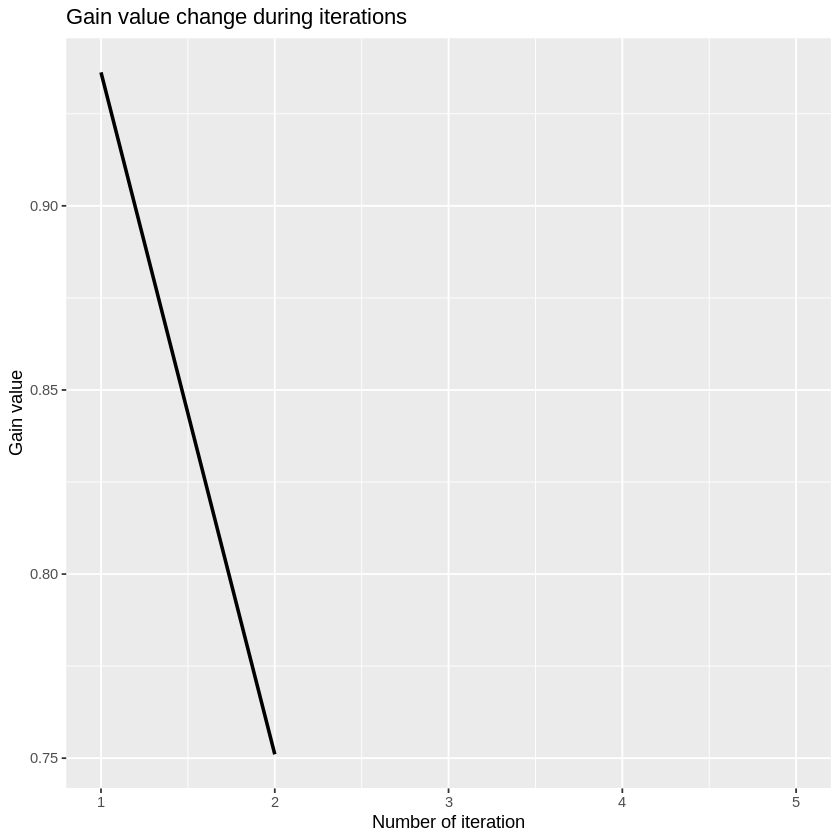

In [113]:
# CTMC MDP model for rescue operational system!!!
# For steady state prob for optimal policy

# prob <- function(opSet = policySet, t, lam, eps, mu) {
#   opTRM = matrix(0, nrow = t+1, ncol = t+1)
#   for (i in 2:t) {
#     opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
#     opTRM[i, i+1] = lam      
#   }
#   opTRM[1, 2] = lam
#   opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)
  
#   k = t+1
#   steady_prob <- matrix(0, nrow=1, ncol=k)
#   state <- matrix(0, nrow=1, ncol=k-1)
#   for (i in 1:(k-1)) {
#     if (i-2 < 0) {
#       state[i] <- (lam/opTRM[i+1,i])
#     } else {
#       state[i] <- state[i-1]*(lam/opTRM[i+1,i])
#     }
#   }
  
#   steady_prob[1] <- (1+sum(state))^-1
#   for (i in 2:k) {
#     steady_prob[i] <- state[i-1]*steady_prob[1]
#   }
#   return(steady_prob)
# }

# Check function to determine new policy is same with current or not 
# checkPolicy = function(policySet, policySetnew) {
#   n = 0
#   for (i in policySet == policySetnew) {
#     if (i == 'FALSE') {
#       n = 1
#     } 
#   } 
#   if (n == 0) {
#     return("TRUE")
#   } else {
#     return("FALSE")
#   }
# } 

# rewardR <- function(costR, RC, nr) {
#   if (RC == "SR") {
#     if (costR < 0) {
#       result = -sqrt(-costR * nr)      
#     } else {
#       result = sqrt(costR * nr)
#     }
#   } else if (RC == "L") {
#     result = costR * nr      
#   } else {
#     if (costR < 0) {
#       result = -(costR * nr)^2      
#     } else {
#       result = (costR * nr)^2      
#     }
#   }
#   return(result)
# }

# rewardT <- function(costT, TC, nt) {
#   if (TC == "SR") {
#     if (costT < 0) {
#       result = -sqrt(-costT * nt)      
#     } else {
#       result = sqrt(costT * nt)
#     }
#   } else if (TC == "L") {
#     result = costT * nt      
#   } else {
#     if (costT < 0) {
#       result = -(costT * nt)^2      
#     } else {
#       result = (costT * nt)^2      
#     }
#   }
#   return(result)
# }

#########################################################
#EDITS: 22ND FEB,2023
#NEW SERVICE RATE STRUCTURE. ADD ORIGINAL ONE AS WELL

# probR = function(nr, nt, eps, mu) {
#   if (nt == 0){
#     result = 0
#   } else {
#     result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)
#   }
#   return(result)
# }

#########################################################

# Define MDP function (for basic policy)
MDP = function(lam, mu, eps, numRescue, numTerror, costR, costT, RC, TC) {
  r = numRescue
  t = numTerror
  # Design the three dimension matrix(i,j,k)
  # k: Index of rescue team
  # i: state(current)
  # j: state(next)
  
  
  #########################################################
  #EDITS: 22ND FEB,2023
  #NEW SERVICE RATES STRUCTURE, ADD ORIGINAL ONE AS WELL
  aijMatrix = array(0, dim = c(t+1,t+1,r+1))
  for (k in 1:(r+1)) {
    for (i in 1:t) {
      aijMatrix[i,i+1,k] <- lam
      if (i > 1) {
        #if (k==4){
          #if(i==4){
            #cat('min(k-1,i-1)',min(k-1,i-1))}}
        aijMatrix[i,i-1,k] <- sum(min(k-1,i-1)*mu+(i-1)*eps)        
      }
    }
    aijMatrix[t+1,t,k] <- (min(k-1,t)*mu+t*eps)
    aijMatrix[1,2,k] <- lam
}

  for (k in 1:(r+1)) {
    for (i in 1:(t+1)) {
      
      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])      
    }
  }
  #########################################################
  
  #print(aijMatrix[4,4,5])
  #cat('meu',mu)
  #cat('epsilon',eps)
  #break
  
  
  # Design the MDP algorithm
  # Value determination
  policy = array(0, dim = c(1,t+1)) 
  policyOld = array(0, dim = c(1,t+1))
  policyNew = array(2, dim=c(1,t+1)) # initially set all decision is 1 in first policy
  policyTrack = array(2, dim=c(1,t+1))
  iteration = 0
  gainMatrix = c()
  
  while (checkPolicy(policyOld, policyNew) == 'FALSE') {
    policyOld = policyNew
    policy = policyNew
    # Design the transition matrix regarding policy
    A = array(0, dim = c(t+1,t+1))
    for (i in 1:length(policy)) {
      A[i,] = aijMatrix[i,,(policy[i])]  
    }

    # Design the cost matrix regarding policy
    q = array(0, dim = c(t+1,1))
    for (i in 1:length(policy)) {
      cost = probR(nr=(policy[i]-1),nt=(i-1),eps,mu)*rewardR(costR, RC, nr=(policy[i]-1))+
        (1-probR(nr=(policy[i]-1),nt=(i-1),eps,mu))*rewardT(costT, TC, nt=(i-1))
      q[i,1] = cost
    }
    newA = cbind(array(1, dim=c(t+1,1)), -A[,1:t])
    solution = solve(newA) %*% q
    gain = solution[1] # First row of solution is gain value
    gainMatrix = append(gainMatrix, gain)
    
    # Policy improvement
    newsolution = array(0, dim=c(t+1,1))
    for (i in 1:t) {
      newsolution[i] = solution[i+1]
    }
    newsolution[t+1] = 0 # Set last v value as 0 to calcultate the test quantity in policy improvement
    improveMatrix = array(0, dim=c(t+1,r+1))
    for (i in 1:(t+1)) {
      for (j in 1:(r+1)) {
        # Cost when we have j rescue operation and i terrorists
        cost = probR(nr=(j-1),nt=(i-1),eps,mu)*rewardR(costR, RC, nr=(j-1))+
          (1-probR(nr=(j-1),nt=(i-1),eps,mu))*rewardT(costT, TC, nt=(i-1))
        improveMatrix[i,j] = cost + aijMatrix[i,,j] %*% newsolution
      }
    }  
    
    # pick the minimum value among the decision
    policyNew = array(1, dim = c(1,t+1))
    for (i in 1:length(policyNew)) {
      policyNew[i] = which.min(improveMatrix[i,])
    }
    iteration = iteration + 1
    policyTrack = rbind(policyTrack, policyNew)
    policyNew
  }
  for (i in 1:length(policyNew)) {
    policyNew[i] = policyNew[i] - 1
  }
  for (i in 1:nrow(policyTrack)) {
    for (j in 1:ncol(policyTrack)) {
      policyTrack[i,j] = policyTrack[i,j] - 1      
    }

  }
  stateName = c()
  for (i in 1:(t+1)) {
    stateName = append(stateName, paste('terror',(i-1)))
  }
  Steady_prob = prob(opSet = policyNew, t, lam, eps, mu)  
  colnames(policyTrack) = stateName
  colnames(policyNew) = stateName
  colnames(Steady_prob) = stateName
  rownames(Steady_prob) = 'Probability'
  rownames(policyNew) = 'Decision'
  result <- list("Iteration" = iteration,
                 "PolicyChange" = policyTrack,
                 "Gain" = gainMatrix,
                 "SteadyStateProb" = Steady_prob,
                 "Optimal_policy" = policyNew)
  
  return(result)
 
}
MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=5, costT=1, RC="QD", TC="QD")
A = MDP(lam = 0.3546, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=1, RC="L", TC="L")


 

# 1 more iteration for example plot
library(ggplot2)
result = MDP(lam = 0.2473, mu = 0.2829, eps = 0.1718, numRescue=3, numTerror=5, costR=1, costT=2, RC="L", TC="L")
result = result$Gain
ddd = array(0, dim=c(5,2))
for (i in 1:5) {
  ddd[i,1] = i
  ddd[i,2] = result[i]  
}
ddd[5,1] = 5
ddd[5,2] = ddd[4,2]

ddd = as.data.frame(ddd)
ggplot(ddd, aes(x=V1, y=V2)) +
  geom_line(size=1) +
  labs(x = 'Number of iteration', y = 'Gain value',
       title = 'Gain value change during iterations')


# Experiment design
rescueSet = c(1,2,3,4,5,6,7,8,9,10)
gainResult = array(0, dim=c(5,length(rescueSet)))
for (j in 1:5) {
  for (i in 1:length(rescueSet)) {
    val = rescueSet[i]
    result = MDP(lam=0.2473, mu=0.2829, eps=0.1718, numRescue=val, numTerror=10, costR=1, costT=j, RC="L", TC="L")
    gainResult[j,i] = tail(result$Gain, 1)
  }  
}
gainResult = as.data.frame(t(gainResult))
gainResult$index = rescueSet
ggplot() +
  geom_line(data=gainResult, aes(x=index, y=V1, color='black'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V2, color='red'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V3, color='blue'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V4, color='purple'), size=1) +
  geom_line(data=gainResult, aes(x=index, y=V5, color='green'), size=1) +
  labs(x = 'Rescue forces capacity', y = 'Gain value of the system',
       title = 'Gain of the system over rescue team capacity') +
  scale_color_identity(name = "Terror cost",
                       labels = c("cost=1", "cost=2", "cost=3", "cost=4", "cost=5"),
                       breaks = c("black", "red", "blue", "purple", "green"),
                       guide = "legend")

In [ ]:
MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=2, RC="L", TC="SR")

In [ ]:
aijMatrix

In [ ]:
aijMatrix

In [ ]:
aijMatrix